predict_abs_error:131.0
fog_abs_error:117.0
clear_abs_error:0.0


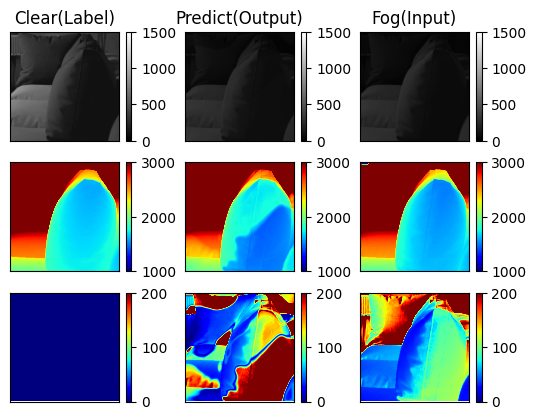

In [26]:
import os
import torch
from torchvision import transforms as T
import numpy as np
import matplotlib.pyplot as plt
from Src.ComplexValuedAutoencoderMain_Torch import end_to_end_Net

DistanceScale=[0,4000]
vmin_depth = 1000
vmax_depth = 3000

vmin_amp = 0
vmax_amp = 1500

vmin_error = 0
vmax_error = 200

F=20 

def main():
    weights_path = 'save_weights/best_model.pth'
    
    fog_amp_path = 'syn_data/predict/syn_amp4000.npy'
    fog_phase_path = 'syn_data/predict/syn_phase4000.npy'
    
    label_phase_path = 'syn_data/predict/raw_phase4000.npy'
    label_amp_path = 'syn_data/predict/raw_amp4000.npy'
    
#     fog_amp_path = 'syn_data/predict/925_19_fog_amp.npy'
#     fog_phase_path = 'syn_data/predict/925_19_fog_phase.npy'
    
#     label_phase_path = 'syn_data/predict/925_19_clear_phase.npy'
#     label_amp_path = 'syn_data/predict/925_19_clear_amp.npy'
    
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    
    model = end_to_end_Net(1,1,1,bilinear=True)
    model.load_state_dict(torch.load(weights_path)['model'])
    model.to(device)
    
    fog_amp = np.load(fog_amp_path)
    fog_phase = np.load(fog_phase_path)
    label_phase = np.load(label_phase_path)
    label_amp = np.load(label_amp_path)

    amp_center_x = (fog_amp.shape[0] // 2)
    amp_center_y = (fog_amp.shape[1] // 2)+100
    phase_center_x = (fog_phase.shape[0] // 2)
    phase_center_y = (fog_phase.shape[1] // 2)+100
    
    half_size = 256 // 2
    
    amp_crop_matrix =  fog_amp[amp_center_x - half_size: amp_center_x + half_size,
                            amp_center_y - half_size: amp_center_y + half_size]
    
    phase_crop_matrix = fog_phase[phase_center_x - half_size: phase_center_x + half_size,
                            phase_center_y - half_size: phase_center_y + half_size]
    
    label_phase_crop_matrix = label_phase[phase_center_x - half_size: phase_center_x + half_size,
                            phase_center_y - half_size: phase_center_y + half_size]
    
    label_amp_crop_matrix = label_amp[amp_center_x - half_size: amp_center_x + half_size,
                            amp_center_y - half_size: amp_center_y + half_size]
                                            
    
    
    fog_dist_avg = cal_dist_avg(phase_crop_matrix)
    label_dist_avg = cal_dist_avg(label_phase_crop_matrix)
    
    amp_crop_matrix = np.where(amp_crop_matrix == 0, 0.0001, amp_crop_matrix)
    
    input_amp = torch.from_numpy(amp_crop_matrix)
    input_phase = torch.from_numpy(phase_crop_matrix)
    
    complex_input = input_amp * torch.exp(1j*input_phase)

    input = complex_input.unsqueeze(0)
    input = input.to(device, dtype=torch.complex64)
    ##model predict
    model.eval()
    with torch.no_grad():
        output = model(input)
        
    output = input - output    
    output_phase = torch.angle(output)
    
    
    output_phase = output_phase.cpu().numpy()
    output_phase = np.squeeze(output_phase)
    output_phase[output_phase<0] += 2*np.pi
    
    output_amp = torch.abs(output)
    output_amp = output_amp.cpu().numpy()
    output_amp = np.squeeze(output_amp)
    
    predict_dist_avg = cal_dist_avg(output_phase)
    
    
    #Abosolute Error
    predict_abs_error = np.abs(label_dist_avg - predict_dist_avg)
    fog_abs_error = np.abs(label_dist_avg - fog_dist_avg)
    clear_abs_error = np.abs(label_dist_avg - label_dist_avg)
    
    print('predict_abs_error:' + str(np.floor(np.average(predict_abs_error))))
    print('fog_abs_error:' + str(np.floor(np.average(fog_abs_error))))
    print('clear_abs_error:' + str(np.floor(np.average(clear_abs_error))))
    
    ##show plt
   
    # input_dist_rescaled = reScale(input_dist, DistanceScale)
    
    plt.subplot(3,3,1)
    plt.imshow(label_amp_crop_matrix,  cmap='gray',  vmin=vmin_amp, vmax=vmax_amp,)
    plt.title('Clear(Label)')
    plt.colorbar()
    plt.xticks([])
    plt.yticks([])
    
    
   
    # predict_dist_rescaled = reScale(predict_dist_avg, DistanceScale)
    plt.subplot(3,3,2)
    plt.imshow(output_amp, cmap='gray',  vmin=vmin_amp, vmax=vmax_amp,)
    plt.title('Predict(Output)')
    plt.colorbar()
    plt.xticks([])
    plt.yticks([])
   
    
    # label_dist_rescaled = reScale(label_dist, DistanceScale)
    plt.subplot(3,3,3)
    plt.imshow(amp_crop_matrix, cmap='gray',  vmin=vmin_amp, vmax=vmax_amp,)
    plt.title('Fog(Input)')
    plt.colorbar()
    plt.xticks([])
    plt.yticks([])
    
    fog_dist_avg_rescaled = reScale(fog_dist_avg, DistanceScale)
    plt.subplot(3,3,4)
    plt.imshow(label_dist_avg, vmin=vmin_depth, vmax=vmax_depth)
    plt.jet()
    # plt.title('Clear distance')
    plt.colorbar()
    plt.xticks([])
    plt.yticks([])
   
    
    plt.subplot(3,3,5)
    plt.imshow(predict_dist_avg, vmin=vmin_depth, vmax=vmax_depth)
    # plt.title('Predict distance')
    plt.colorbar()
    plt.xticks([])
    plt.yticks([])
   
    
    
    plt.subplot(3,3,6)
    plt.imshow(fog_dist_avg, vmin=vmin_depth, vmax=vmax_depth)
    # plt.title('Fog distance')
    plt.colorbar()
    plt.xticks([])
    plt.yticks([])
  
    
    plt.subplot(3,3,7)
    plt.imshow(clear_abs_error, vmin=vmin_error, vmax=vmax_error)
    # plt.title('Clear Abosulte Error' )
    plt.colorbar()
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(3,3,8)
    plt.imshow(predict_abs_error, vmin=vmin_error, vmax=vmax_error)
    # plt.title('Predict Abosulte Error' )
    plt.colorbar()
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(3,3,9)
    plt.imshow(fog_abs_error, vmin=vmin_error, vmax=vmax_error)
    # plt.title('Fog Abosulte Error', )
    plt.colorbar()
    plt.xticks([])
    plt.yticks([])
    
    
    plt.show()
    
    
def cal_dist_avg(output_phase):
    unAmbiguousRange = (0.5*299792458)/(F*1000)
    coefRad = unAmbiguousRange / (2*np.pi)
    dist = (output_phase)*coefRad
    # dist = np.resize(dist, (px_height, px_width))
    return dist

def reScale(pixArray,scale):
    super_threshold_indices = pixArray >= scale[1]
    pixArray[super_threshold_indices] = scale[1]-1
    super_threshold_indices = pixArray < scale[0]
    pixArray[super_threshold_indices] = scale[0]
    pixArray=pixArray-scale[0]
    pixArray=pixArray*(65536/(scale[1]-scale[0]))
    pixArray8b = (pixArray/256).astype('uint8')
    return pixArray8b

    
if __name__ == '__main__':
    main()